env: OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml
[Machine2:73612] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     

/home/pablo/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/source.py:390: FutureWarning: This class is deprecated in favor of 'IndependentSource'
  warnings.warn("This class is deprecated in favor of 'IndependentSource'", FutureWarning)


 Reading O16 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/O16.h5
 Reading Zr90 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/Zr90.h5
 Reading Zr91 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/Zr91.h5
 Reading Zr92 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/Zr92.h5
 Reading Zr94 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/Zr94.h5
 Reading Zr96 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/Zr96.h5
 Reading He3 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/He3.h5
 Reading He4 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/He4.h5
 Reading H1 from /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/H1.h5
 Reading c_H_in_H2O from
 /home/pablo/internship/xs_for_input/jeff-3.3-hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 250 K
 Maximum neutron data temperature: 2500 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for He3
 Initializing source

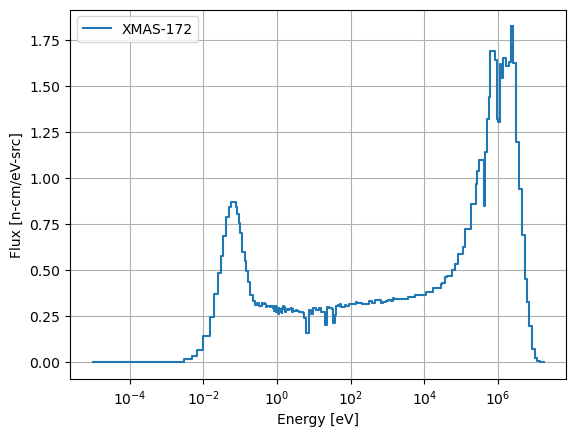

[1.50500005e-03 4.00000000e-03 5.95000000e-03 8.45000000e-03
 1.25000000e-02 1.75000000e-02 2.25000000e-02 2.75000000e-02
 3.25000000e-02 3.85000000e-02 4.60000000e-02 5.40000000e-02
 6.25000000e-02 7.20000000e-02 7.85000000e-02 8.75000000e-02
 9.75005000e-02 1.07500500e-01 1.24500000e-01 1.37000000e-01
 1.50000000e-01 1.70000000e-01 1.84500000e-01 2.04500000e-01
 2.34000000e-01 2.64000000e-01 2.90000000e-01 3.07250000e-01
 3.17250000e-01 3.35000000e-01 3.70500000e-01 3.95500000e-01
 4.16500000e-01 4.59000000e-01 4.92500000e-01 5.20000000e-01
 5.82500000e-01 6.65000000e-01 7.42500000e-01 7.85000000e-01
 8.20000000e-01 8.55000000e-01 8.85000000e-01 9.20000000e-01
 9.40000000e-01 9.61000000e-01 9.79000000e-01 9.91000000e-01
 1.00800000e+00 1.02750000e+00 1.04000000e+00 1.05800000e+00
 1.08400000e+00 1.10350000e+00 1.11767500e+00 1.13767500e+00
 1.16000000e+00 1.20250000e+00 1.26750000e+00 1.31875000e+00
 1.35375000e+00 1.40749000e+00 1.45999000e+00 1.48750000e+00
 1.54500000e+00 1.630000

In [9]:
import sys
import os 
import openmc
import numpy as np
import matplotlib.pyplot as plt
import openmc.mgxs as mgxs
import math
import pickle
from IPython.display import Image
import openmc.mgxs

%env OPENMC_CROSS_SECTIONS=/home/pablo/internship/xs_for_input/cross_sections.xml



model=openmc.Model()

#Materials

uo2 = openmc.Material(name='uo2')
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

helium=openmc.Material(name='helium')
helium.add_element('helium',1)
helium.set_density('g/cm3',8e-4)

water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

model.materials = openmc.Materials([uo2, zirconium, water,helium])


model.materials.export_to_xml()

#Geometry

#create surface
fuel_outer_radius = openmc.ZCylinder(r=0.39)
clad_inner_radius = openmc.ZCylinder(r=0.40)
clad_outer_radius = openmc.ZCylinder(r=0.46)

pitch = 1.26
left = openmc.XPlane(-pitch/2, boundary_type='reflective')
right = openmc.XPlane(pitch/2, boundary_type='reflective')
bottom = openmc.YPlane(-pitch/2, boundary_type='reflective')
top = openmc.YPlane(pitch/2, boundary_type='reflective')

#create region of interest
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
water_region = +left & -right & +bottom & -top & +clad_outer_radius

#create cell
fuel = openmc.Cell(name='fuel')
fuel.fill = uo2
fuel.region = fuel_region

gap = openmc.Cell(name='gap')
gap.fil=helium
gap.region = gap_region

clad = openmc.Cell(name='clad')
clad.fill = zirconium
clad.region = clad_region

moderator = openmc.Cell(name='moderator')
moderator.fill = water
moderator.region = water_region

root_universe = openmc.Universe(cells=(fuel, gap, clad, moderator))
model.geometry = openmc.Geometry(root_universe)

model.geometry.export_to_xml()

#Parameter

point = openmc.stats.Point((0, 0, 0))
source = openmc.Source(space=point)

batches = 50
inactive = 10
particles = 3000

settings = openmc.Settings()
settings = openmc.Settings()
settings.batches = batches
settings.inactive = inactive
settings.particles = particles
##settings.output = {'tallies': False}
#settings.run_mode = 'eigenvalue'
#settings.verbosity = 4

point = openmc.stats.Point((0, 0, 0))
source = openmc.Source(space=point)

model.settings = settings

model.settings.export_to_xml()

#MGXS


#create energy group discretisation
VIMS69=np.array([1e-11, 5e-09, 1e-08, 1.5e-08, 2e-08, 2.5e-08, 3e-08, 3.5e-08, 4.2e-08, 5e-08, 5.8e-08, 6.7e-08, 8e-08, 1e-07, 1.4e-07, 1.8e-07, 2.2e-07, 2.5e-07, 2.8e-07, 3e-07, 3.2e-07, 3.5e-07, 4e-07, 5e-07, 6.25e-07, 7.8e-07, 8.5e-07, 9.1e-07, 9.5e-07, 9.72e-07, 9.96e-07, 1.02e-06, 1.045e-06, 1.071e-06, 1.097e-06, 1.123e-06, 1.15e-06, 1.3e-06, 1.5e-06, 2.1e-06, 2.6e-06, 3.3e-06, 4e-06, 9.877e-06, 1.5968e-05, 2.77e-05, 4.8052e-05, 7.55014e-05, 0.000148729, 0.000367263, 0.000906899, 0.0014251, 0.00223945, 0.0035191, 0.00553, 0.009118, 0.01503, 0.02478, 0.04085, 0.06734, 0.111, 0.183, 0.3025, 0.5, 0.821, 1.353, 2.231, 3.679, 6.0655, 10.0])

#openmc.mgxs.GROUP_STRUCTURES.keys() contain XMAS172
XMAS172=np.array([1.00001e-11, 3e-09, 5e-09, 6.9e-09, 1e-08, 1.5e-08, 2e-08, 2.5e-08, 3e-08, 3.5e-08, 4.2e-08, 5e-08, 5.8e-08, 6.7e-08, 7.7e-08, 8e-08, 9.5e-08, 1e-07, 1.15e-07, 1.34e-07, 1.4e-07, 1.6e-07, 1.8e-07, 1.89e-07, 2.2e-07, 2.48e-07, 2.8e-07, 3e-07, 3.145e-07, 3.2e-07, 3.5e-07, 3.91e-07, 4e-07, 4.33e-07, 4.85e-07, 5e-07, 5.4e-07, 6.25e-07, 7.05e-07, 7.8e-07, 7.9e-07, 8.5e-07, 8.6e-07, 9.1e-07, 9.3e-07, 9.5e-07, 9.72e-07, 9.86e-07, 9.96e-07, 1.02e-06, 1.035e-06, 1.045e-06, 1.071e-06, 1.097e-06, 1.11e-06, 1.123e-06, 1.15e-06, 1.17e-06, 1.235e-06, 1.3e-06, 1.3375e-06, 1.37e-06, 1.44e-06, 1.475e-06, 1.5e-06, 1.59e-06, 1.67e-06, 1.755e-06, 1.84e-06, 1.93e-06, 2.02e-06, 2.1e-06, 2.13e-06, 2.36e-06, 2.55e-06, 2.6e-06, 2.72e-06, 2.76792e-06, 3.3e-06, 3.38075e-06, 4e-06, 4.12925e-06, 5.043477e-06, 5.34643e-06, 6.160116e-06, 7.523983e-06, 8.315287e-06, 9.189814e-06, 9.905554e-06, 1.122446e-05, 1.370959e-05, 1.592827e-05, 1.945484e-05, 2.260329e-05, 2.49805e-05, 2.760773e-05, 3.051126e-05, 3.372015e-05, 3.726653e-05, 4.0169e-05, 4.551744e-05, 4.82516e-05, 5.157802e-05, 5.559513e-05, 6.790405e-05, 7.567357e-05, 9.166088e-05, 0.000136742, 0.0001486254, 0.000203995, 0.0003043248, 0.0003717032, 0.0004539993, 0.0006772874, 0.0007485183, 0.0009142423, 0.001010394, 0.001234098, 0.001433817, 0.001507331, 0.002034684, 0.002248673, 0.003354626, 0.003526622, 0.005004514, 0.005530844, 0.007465858, 0.00911882, 0.01113775, 0.01503439, 0.01661557, 0.02478752, 0.02739445, 0.029283, 0.03697864, 0.04086771, 0.05516564, 0.06737947, 0.08229747, 0.11109, 0.1227734, 0.1831564, 0.2472353, 0.2732372, 0.3019738, 0.407622, 0.450492, 0.4978707, 0.5502322, 0.6081006, 0.82085, 0.9071795, 1.002588, 1.108032, 1.224564, 1.353353, 1.652989, 2.018965, 2.231302, 2.46597, 3.011942, 3.678794, 4.49329, 5.488116, 6.065307, 6.7032, 8.187308, 10.0, 11.618343, 13.840307, 14.918247, 17.33253, 19.64033])



energies_xmas = openmc.mgxs.GROUP_STRUCTURES['XMAS-172']
xmas_filter = openmc.EnergyFilter(openmc.mgxs.GROUP_STRUCTURES['XMAS-172'])
cell_filter = openmc.CellFilter([fuel.id])
tally = openmc.Tally()
tally.filters = [xmas_filter,cell_filter]
tally.scores = ['flux']
model.tallies = [tally]

statepoint_filename = model.run()
ce_spfile = './statepoint_ce.h5'
os.rename(statepoint_filename, ce_spfile)
ce_sumfile = './summary_ce.h5'
os.rename('summary.h5', ce_sumfile)
sp = openmc.StatePoint(ce_spfile, autolink=False)
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)


t = sp.tallies[tally.id]
flux_mean = t.mean.ravel()
flux_unc = t.std_dev.ravel()

dE=np.diff(energies_xmas)
Emid=energies_xmas[:-1]+dE/2

fig, ax = plt.subplots()
ax.step(energies_xmas[:-1], Emid*flux_mean/dE, where='post', label='XMAS-172')
ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()
plt.show()



dE=np.diff(energies_xmas)
Emid=energies_xmas[:-1]+dE/2
print(Emid)



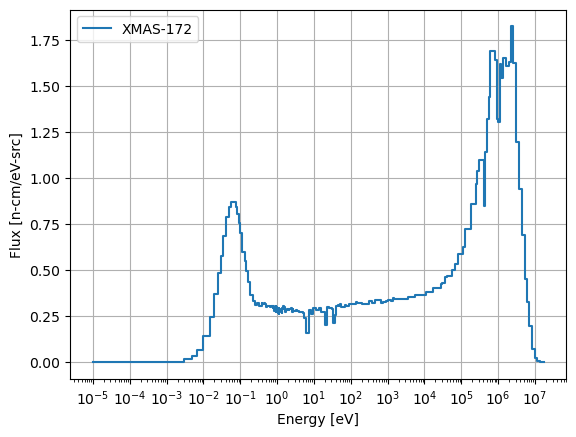

In [44]:
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import LogLocator

fig, ax = plt.subplots()
ax.step(energies_xmas[:-1], Emid*flux_mean/dE, where='post', label='XMAS-172')
ax.set_xscale('log')
#ax.xaxis.set_major_locator(FixedLocator(locs = np.logspace(-4,7,12)))
#from matplotlib.ticker import ticker as mticker
#ax.xaxis.set_major_locator(mticker.LogLocator(numticks=999))
#ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999,subs='auto'))

ax.xaxis.set_major_locator(FixedLocator(locs=np.logspace(-5, 7, 13)))
locmin=LogLocator(base=10,subs=np.linspace(0,1.0,11)[1:-1],numticks=1000)
ax.xaxis.set_minor_locator(locmin)


#ax.set_yscale('log')
ax.set_xlabel('Energy [eV]')
ax.set_ylabel('Flux [n-cm/eV-src]')
ax.grid()
ax.legend()
ax.set_xlim(1,100)
ax.set_ylim(0.15,0.35)
plt.show()

In [ ]:
ax.get_xaxis().get_major_formatter().
ax.xaxis.set_major_locator(FixedLocator(locs = np.logspace(-4,7,12))
